In [1]:
from music21 import *
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import pandas as pd
from ast import literal_eval

notes_df = pd.read_csv ('Dataset/notes.csv')
train_df = pd.read_csv ('Dataset/trainset.csv')
validation_df = pd.read_csv ('Dataset/validationset.csv')

data_train = train_df[['x_tr','future']].to_numpy()
data_validation = validation_df[['x_val','future']].to_numpy()

x_tr_string = data_train[:,0]
y_tr_string = data_train[:,1]
x_tr = []
y_tr = []
for i in x_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_tr = [int(j) for j in i.split()]
    x_tr.append(input_x_tr)

for i in y_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_tr = [int(j) for j in i.split()]
    y_tr.append(input_y_tr)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
    
# print(x_tr.shape,y_tr.shape)

x_val_string = data_validation[:,0]
y_val_string = data_validation[:,1]
x_val = []
y_val = []
for i in x_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_val = [int(j) for j in i.split()]
    x_val.append(input_x_val)

for i in y_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_val = [int(j) for j in i.split()]
    y_val.append(input_y_val)
x_val = np.array(x_val)
y_val = np.array(y_val)

# print(x_val.shape,y_val.shape)

notes_ = notes_df.to_numpy()[:,1]
unique_notes_reverse = dict(enumerate(notes_.flatten(), 1))
unique_notes = {value : key for (key, value) in unique_notes_reverse.items()}


In [3]:
from MusicDataset import *
batch_size = 8
train_set = MusicDataset(x_tr,y_tr)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [4]:
val_set = MusicDataset(x_val,y_val)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

**DataLoader**

**For Wavenet Model (Ignore for now)**

In [5]:
from Models import Wavenet,LSTM
# Net = Wavenet.Wavenet(len(unique_notes),blocks=4,layers = 2)
Net = LSTM.Sequence(len(unique_notes),32)
Net.to(device)

Sequence(
  (embedding): Embedding(173, 100)
  (lstm): LSTM(100, 256, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (softmax): Softmax(dim=None)
  (linear3): Linear(in_features=128, out_features=173, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

**Checking the model**

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

**Use the line below when you want to change learning parameters in between**

In [7]:
import time , sys
baseDir = '/home/god-particle/Desktop/Music_Gen_AI'
expDir = os.path.join(baseDir, 'trained_model_cache', time.strftime("%d_%m_%Y_%H_%M"))
lossDir = os.path.join(expDir, 'loss')
os.makedirs(expDir, exist_ok=True)
os.makedirs(lossDir, exist_ok=True)
print(baseDir,expDir)

/home/god-particle/Desktop/Music_Gen_AI /home/god-particle/Desktop/Music_Gen_AI/trained_model_cache/04_09_2021_18_16


In [12]:
loss_history = []
best_val_acc = 0
training_mode_list = ["Next_Predict_Mode","Future_Predict_Mode"]
training_mode = "Next_Predict_Mode"
# training_mode = "Future_Predict_Mode"
future_preds = 5

In [13]:
import timeit


''' TRAINING THE MODEL '''
correct_preds = 0
total_preds = 0
for epoch in range(20): 
    running_loss = 0.0
    start = timeit.default_timer()
    for i, data in enumerate(trainloader, 0):
        input , label = data
        optimizer.zero_grad()
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device),input.shape[0])
            loss = criterion(output.to(device), label[:,0].to(device))
            loss.backward()
            optimizer.step()
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))

            running_loss += loss.item()
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if (i % 300 == 299  ):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            loss_history.append(running_loss/300)
            running_loss = 0.0
    stop = timeit.default_timer()
    print(f"Training Time for Epoch :{epoch} \n {stop-start} seconds\n")
    train_acc =  float(correct_preds)/float(total_preds) *100 
    trainreport ="Training Accuracy : \n correct predictions  : {} \n total predictions : {} \n Training Accuracy : {} \n ------------------------\n".format(correct_preds,total_preds,train_acc)
    print(trainreport)     
    correct_preds = 0
    total_preds = 0
    val_loss = 0
    start = timeit.default_timer()
    for i, data in enumerate(validationloader, 0):
        input , label = data
        if training_mode == training_mode_list[0]:
            output = Net(input.to(device),input.shape[0])
            loss = criterion(output.to(device), label[:,0].to(device))
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))
            val_loss += loss.item()
            
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))

            val_loss += loss.item()
    stop = timeit.default_timer()
    print(f"Validation Time for Epoch :{epoch} \n {stop-start} seconds\n")
    val_acc = float(correct_preds)/float(total_preds) *100
    val_loss = float(val_loss)/float(total_preds)
    valreport ="Validation Accuracy : \n correct predictions  : {} \n total predictions : {} \n Val-Loss : {} \n Val-Accuracy :{}----------------------------------\n".format(correct_preds,total_preds,val_loss,val_acc )
    print(valreport)
    
    if(val_acc > best_val_acc):
        print('Updating the model')
        best_val_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": Net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_acc": train_acc,
            "valid_acc": val_acc
        }
        torch.save(checkpoint, os.path.join(expDir, 'checkpoint.tar'))
        torch.save(Net, os.path.join(expDir, 'model.pth'))
    
    correct_preds = 0
    total_preds = 0


print('Finished Training')

[1,   300] loss: 4.800
[1,   600] loss: 4.807
[1,   900] loss: 4.772
[1,  1200] loss: 4.772
[1,  1500] loss: 4.796
[1,  1800] loss: 4.772
[1,  2100] loss: 4.760
[1,  2400] loss: 4.745
[1,  2700] loss: 4.714
[1,  3000] loss: 4.636
[1,  3300] loss: 4.651
[1,  3600] loss: 4.642
[1,  3900] loss: 4.616
[1,  4200] loss: 4.662
[1,  4500] loss: 4.633
[1,  4800] loss: 4.652
[1,  5100] loss: 4.629
[1,  5400] loss: 4.633
[1,  5700] loss: 4.569
[1,  6000] loss: 4.579
[1,  6300] loss: 4.564
[1,  6600] loss: 4.576
[1,  6900] loss: 4.557
Training Time for Epoch :0 
 253.59919308200006 seconds

Training Accuracy : 
 correct predictions  : 1311 
 total predictions : 56095 
 Training Accuracy : 2.337106694001248 
 ------------------------

Validation Time for Epoch :0 
 58.391588356000284 seconds

Validation Accuracy : 
 correct predictions  : 504 
 total predictions : 16028 
 Val-Loss : 0.5735706819957231 
 Val-Accuracy :3.1444971300224602----------------------------------

Updating the model
[2,   300

KeyboardInterrupt: 

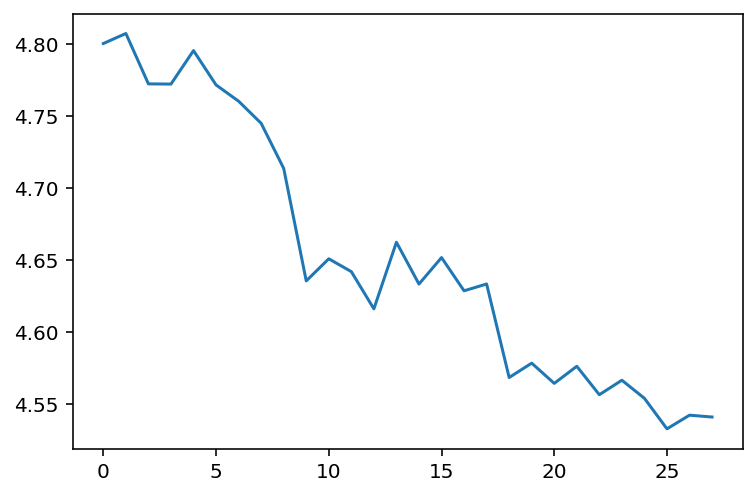

In [14]:
plt.figure()
plt.plot(loss_history)
# plt.savefig(lossDir + '/loss_history.png')

In [ ]:
# path='/content/drive/MyDrive/schubert/sine_model.pth'
# path='/content/drive/MyDrive/schubert/lstmmodel1.pth'
path='/content/drive/MyDrive/schubert/sine_wavenet1.pth'
torch.save(Net.state_dict(), path)

In [ ]:
# path='/content/drive/MyDrive/schubert/sine_model.pth'
# path='/content/drive/MyDrive/schubert/lstmmodel1.pth'
checkpoint_path='/home/god-particle/Desktop/Music_Gen_AI/trained_model_cache/29_08_2021_23_57/checkpoint.tar'
Net = LSTM.Sequence(len(unique_notes),32);
checkpoint = torch.load(checkpoint_path)
Net.load_state_dict(checkpoint["model_state_dict"])
print(checkpoint["epoch"])
# Net = Wavenet(len(unique_x),blocks=4,layers = 2)
# Net.load_state_dict(torch.load(path))

correct_preds = 0
total_preds = 0
with torch.no_grad():
  for i, data in enumerate(validationloader, 0):
    input , label = data
    output = Net(input,input.shape[0])
    total_preds += input.shape[0]
    correct_preds += torch.sum(torch.argmax(output,1) == label)
    

report ="correct predictions  : {} \n total predictions : {} \n Accuracy : {}".format(correct_preds,total_preds, correct_preds/total_preds *100)
print(report)


**Testing the Model by training sinosoids**



*   Uncomment the code chunk below to test o sinosoids 
*   dont run above code if training for sinosoids. Variable names are mostly same



In [ ]:
# time = np.linspace(1,10,10000)
# # print(time)
# y = np.sin(20*time)
# # plt.figure();
# # plt.plot(y)
# func = np.round(y,decimals=2)
# # print(y[:100])
# no_of_timesteps = 32
# x = []
# y = []


# for i in range(0, len(func) - no_of_timesteps-1, 1):
    
#     #preparing input and output sequences
#     input_ = func[i:i + no_of_timesteps]
#     output = func[i+no_of_timesteps+1]
    
#     x.append(input_)
#     y.append(output)
        
# x=np.array(x)
# y=np.array(y)

# unique_x = list(set(x.ravel()))
# x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))
# x_seq=[]
# for i in x:
#     temp=[]
#     for j in i:
#         #assigning unique integer to every note
#         temp.append(x_note_to_int[j])
#     x_seq.append(temp)
    
# x_seq = np.array(x_seq)

# unique_y = list(set(y))
# y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
# y_seq=np.array([x_note_to_int[i] for i in y])
